In [1]:
cur_date = "092622"

library(readxl)
library(tidyverse)
library(reshape2)
library(factoextra)
library(RColorBrewer)

# reading in file
allostatic_loading_df = data.frame(read_excel("Input/Allostatic_Mediator_Data_061722ap.xlsx", sheet = 2))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




In [2]:
head(allostatic_loading_df)

,Study,Original_Subject_Number,Subject_Number,Group,Subject_ID,Sex,Age,Race,Category,Variable,Value
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
1,FM2,97,1,CS,CS_1,M,18,B,AL Biomarker,Cortisol,140.304
2,FM2,99,2,CS,CS_2,F,20,W,AL Biomarker,Cortisol,246.542
3,FM2,101,3,CS,CS_3,F,20,W,AL Biomarker,Cortisol,50.878
4,FM2,98,4,CS,CS_4,F,21,W,AL Biomarker,Cortisol,137.387
5,TCORS LAIV,39,5,CS,CS_5,M,21,W,AL Biomarker,Cortisol,116.602
6,FM2,100,6,CS,CS_6,F,22,W,AL Biomarker,Cortisol,54.030


Using PCA to determine which mediators potentially drive altered cytokine expression. 

In [3]:
cytokine_df = allostatic_loading_df %>%
    # psudeo log transforming makes the data have a more a normal distribution
    # it also centers and scales the data, which is necessary for PCA
    mutate(Value = log2(Value + 1)) %>%
    filter(Category == "Cytokine") %>%
    pivot_wider(names_from = Variable, values_from = Value) %>%
    column_to_rownames(var = "Subject_ID")

# removing uneeded cols
cytokine_pca_prep_df = cytokine_df[,9:19]

head(cytokine_pca_prep_df)

,IP10,IFNg,IL10,IL12p70,IL13,IL1B,IL2,IL4,IL6,IL8,TNFa
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CS_1,0.1361914,3.312420,1.0211400,6.283168,6.171261,0.142650448,12.969672,0.07429537,0.9783190,5.385191,1.2651112
CS_2,0.4393572,5.384603,1.8726551,6.831303,7.071569,0.232921800,11.057095,0.21880340,1.4292327,5.496325,1.8823443
CS_3,0.2797684,3.415356,0.5470043,6.663562,6.416508,0.212762292,11.099906,0.09335380,1.7419846,5.292506,1.9158616
CS_4,0.1163648,5.163017,1.0095672,6.305512,7.457356,0.699233289,11.635748,0.26521978,2.5903201,5.368305,1.8044068
CS_5,6.9545569,1.507441,0.4466146,5.626183,4.883828,0.001005964,9.566527,0.05807488,0.2941251,3.418092,0.8921607
CS_6,0.1473067,4.053890,0.7235306,6.328044,6.219790,0.115716941,10.834965,0.08739738,0.8457933,4.536366,1.6173436


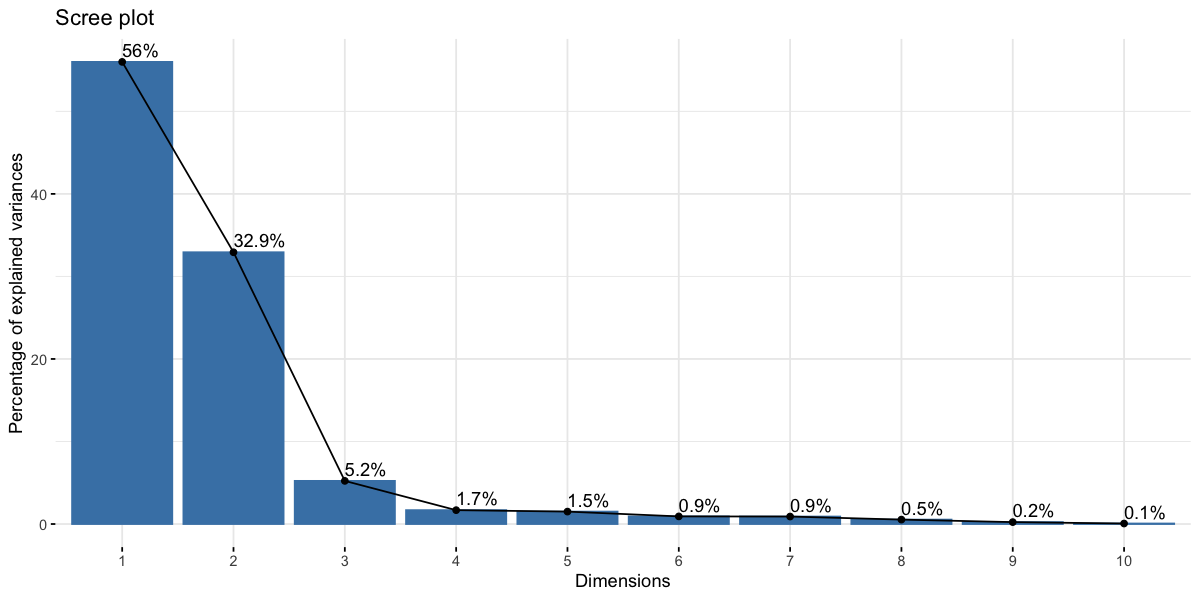

In [4]:
# running PCA
pca_cytokine = prcomp(cytokine_pca_prep_df)

# viewing scree plots to see how much of the variance was captured in first 2 eigenvectors
options(repr.plot.width=10, repr.plot.height=5) #changing size
fviz_eig(pca_cytokine, addlabels = TRUE)

Warning message:
“ggrepel: 25 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


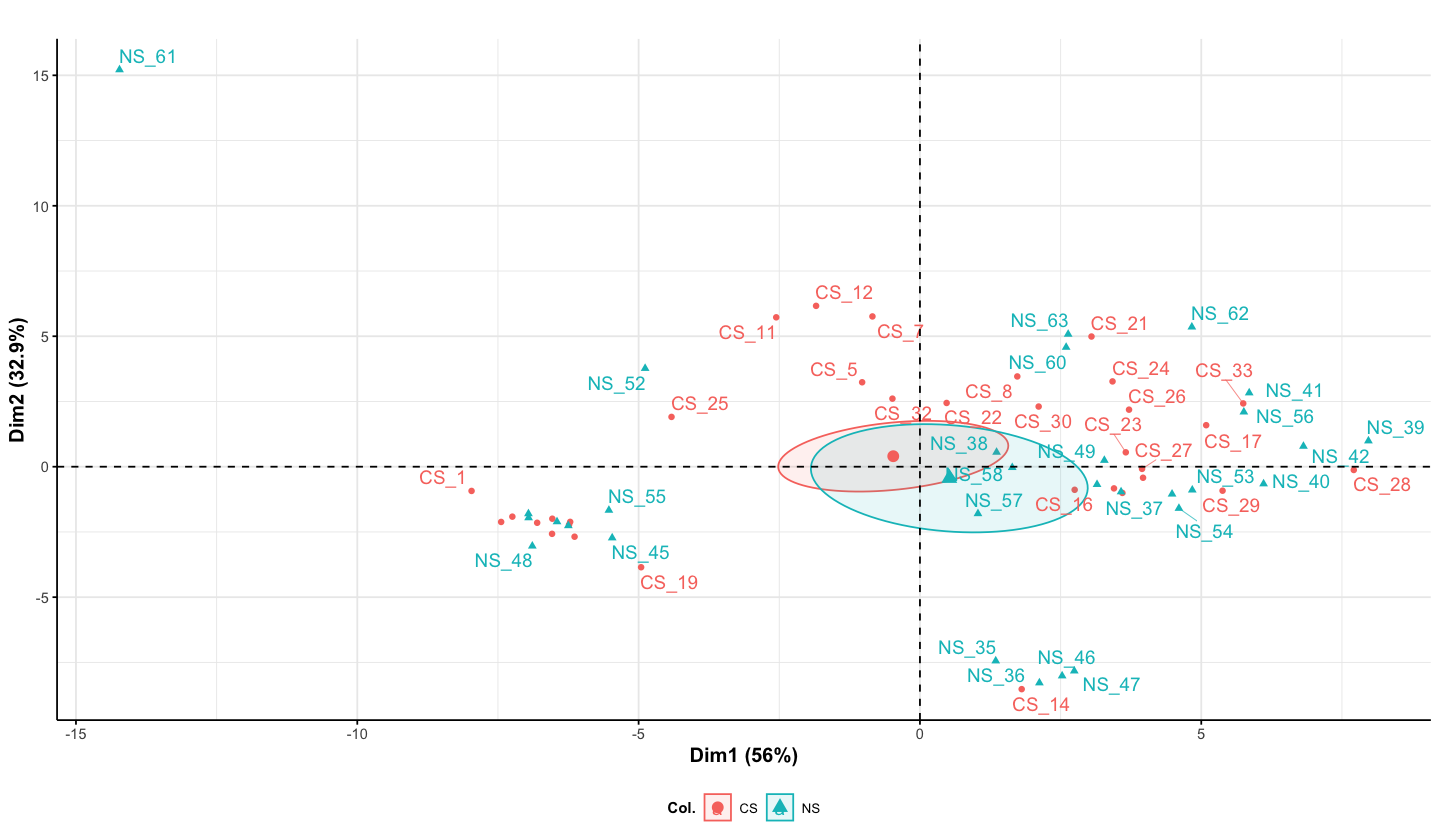

In [5]:
# visualizing all data to detect outlier subjects
options(repr.plot.width=12, repr.plot.height=7) #changing size
fviz_pca_ind(pca_cytokine, 
             col.ind = cytokine_df$Group, # color by Group
             #adding 95% confidence ellipses for each group
             addEllipses = TRUE, # Concentration ellipses
             ellipse.type = "confidence",
             repel = TRUE, title = "") +
theme(axis.line = element_line(colour = "black"), #making x and y axes black
      legend.title = element_text(size = 9, face = "bold"),
      legend.text = element_text(size = 8),
      legend.position = 'bottom',
      axis.title = element_text(face = "bold", size = rel(1.1))) #changes axis titles

It looks like NS_61 that will be removed, but I will use a quantitative cutoff to ensure others aren't missed.

In [23]:
outlier_detection = function(pca_df){
    # """
    # Creating a scoring function for to detect PCA subject outliers. 
    # :param (input): PCA df (df)
    # :output: outlier names
    # """
    
    # getting scores
    scores = pca_df$x[,1:2]
    # identifying samples that are > 6 standard deviations away from the mean
    outlier_indices = apply(scores, 2, function(x) which( abs(x - mean(x)) > (6 * sd(x)) )) %>%
        Reduce(union, .)
    # getting sample names
    outliers = rownames(scores)[outlier_indices]
    
    return(outliers)
}

# calling fn
subject_outliers = outlier_detection(pca_cytokine)
subject_outliers

character(0)

No were identified, so all subjects will be kept.

Now determining contributions of each contribution on the first two eigenvectors.

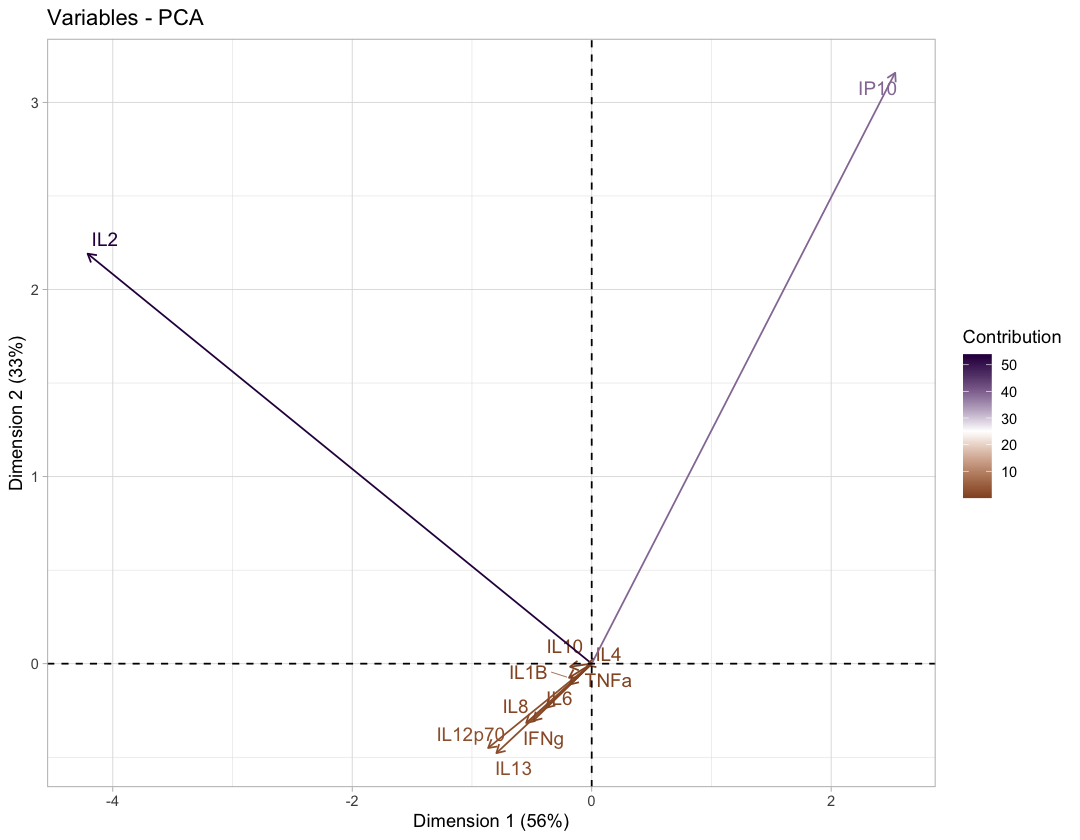

In [53]:
options(repr.plot.width=9, repr.plot.height=7) #changing size
# choosing colors
brewer_colors = brewer.pal(10, "PuOr")

fviz_pca_var(pca_cytokine, col.var = "contrib", repel = TRUE) +
  xlab('Dimension 1 (56%)') + ylab('Dimension 2 (33%)') + #changing axis labels
  theme_light() + 

  # changing colors
  scale_color_gradient2(name = "Contribution", low = brewer_colors[1], mid = "white", high = brewer_colors[10], 
                       midpoint = 25) 

It's hard to see everything at the bottom, so I made a bar chart below that contains the same information. However, it only shows contributions from the first eigenvector.

In [68]:
loadings = data.frame(pca_cytokine$rotation) %>%
  rownames_to_column(var = "Cytokine") %>%
  select(Cytokine, PC1, PC2) %>%
  pivot_longer(cols = c("PC1", "PC2"), names_to = "PC", values_to = "Loading") %>%
  # adding an additional bogus col for the later heat map to work
  mutate(Category = "Cytokine")

head(loadings)

Cytokine,PC,Loading,Category
<chr>,<chr>,<dbl>,<chr>
IP10,PC1,0.494118788,Cytokine
IP10,PC2,0.802817435,Cytokine
IFNg,PC1,-0.106609178,Cytokine
IFNg,PC2,-0.080562267,Cytokine
IL10,PC1,-0.035263013,Cytokine
IL10,PC2,-0.004203862,Cytokine


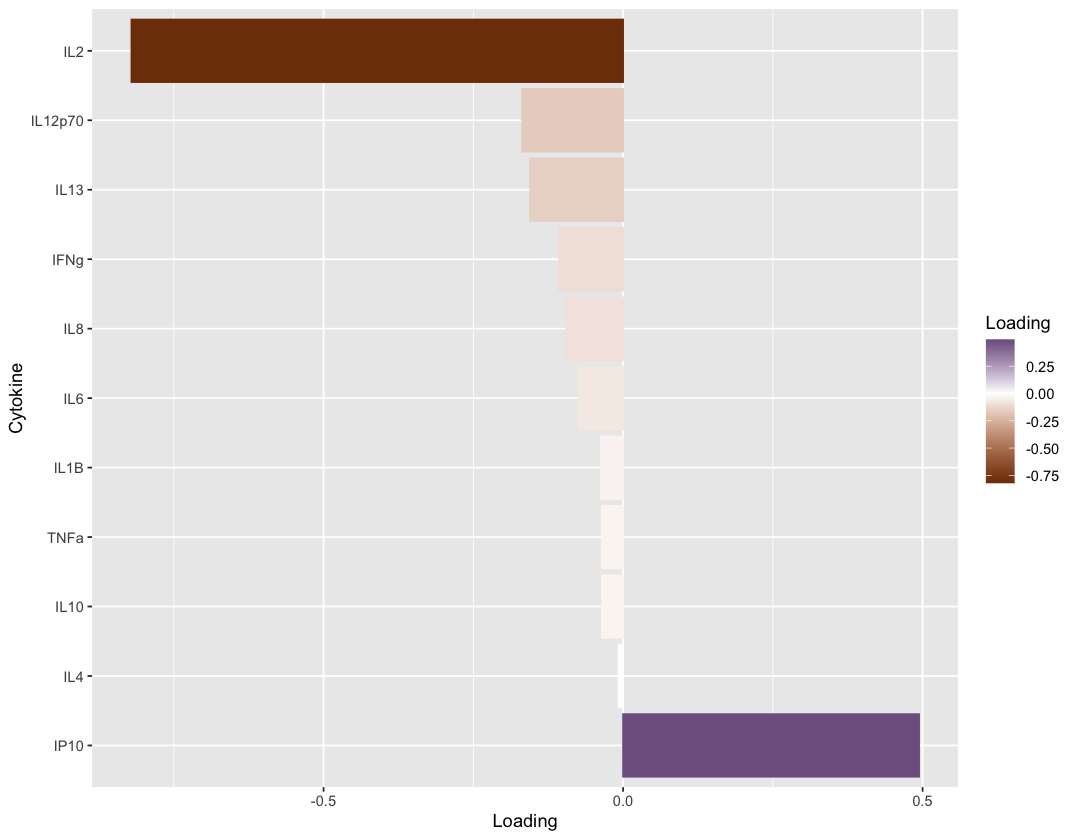

In [69]:
ggplot(loadings %>%
         #filtering for PC1 
         filter(PC == "PC1"), 
       aes(y = reorder(Cytokine, -Loading), x = Loading, color = Loading, fill = Loading)) + 
  geom_bar(stat = "identity") + 

  # changing color
  scale_color_gradient2(low = brewer_colors[1], mid = "white", high = brewer_colors[10]) +
  scale_fill_gradient2(low = brewer_colors[1], mid = "white", high = brewer_colors[10]) +
  ylab("Cytokine")

**Note:** Both the contributions and loading quantifying a variables impact on the eigenvector. However, their scales are different and the loadings (visualized in the last figure) capture directionality of that impact. 